In [88]:
from IPython.display import clear_output

In [90]:
!pip install timm
!pip install fastai
clear_output()


In [19]:
import timm
from timm import create_model

In [1]:
seed = 999
IMG_SIZE = 224
BATCH_SIZE = 14
NUM_WORKERS = 8

In [2]:
import torch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# Load Train Dataset

In [3]:
#!rm -rf /workspace/dataset/sick/dataset/*.ipynb_checkpoints
!rm -rf `find -type d -name .ipynb_checkpoints`

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
transforms = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize(IMG_SIZE)
)

img_data = ImageFolder(root="/workspace/dataset/sick/dataset",
                      transform = transforms)


In [5]:
set(img_data.targets), img_data.classes

({0, 1, 2, 3, 4}, ['노균병', '녹병', '잿빛곰팡이병', '정상', '흰가루병'])

In [6]:
# Look how img_data varaiable are composed
for i in img_data.imgs:
    print(i)
    break

('/workspace/dataset/sick/dataset/노균병/ddd (1).jpeg', 0)


In [7]:
import pandas as pd
from sklearn.utils import shuffle

df = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
df = pd.DataFrame(df)
train = shuffle(df)

# Total train dataset 
len(train) 

763

In [9]:
n = len(img_data.classes)

In [10]:
nums =[0]*n
for t in train['label']:
    nums[t]+=1
    
# Numbers of Image about each class
nums

[77, 59, 196, 359, 72]

In [11]:
from fastai.vision.all import *

In [12]:
data = ImageDataLoaders.from_df(train, # train DataFrame
                                valid_pct=0.2, #90-10 train-validation split
                           seed=seed, #seed
                           fn_col='path', 
                           label_col='label',
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           bs=BATCH_SIZE, 
                           num_workers=NUM_WORKERS, 
                                # Augmentation
                           item_tfms=Resize(IMG_SIZE),
                           batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

In [13]:
#print(img_data.class_to_idx)
#data.show_batch()

In [14]:
# check available batch size
for i in range(1,1000):
    if (len(data.train) + len(data.valid)) == (len(df)//i):
        print(i)

14


In [15]:
assert (len(data.train) + len(data.valid)) == (len(df)//BATCH_SIZE)

In [16]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

61

# Load Model 

In [17]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '/workspace/swin_base_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth'

In [20]:
model = create_model('swin_base_patch4_window7_224', 
                     pretrained=True,
                     num_classes=len(img_data.classes))

In [21]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

9

In [22]:
learn = Learner(data,
                model,
                opt_func = QHAdam,
                loss_func= FocalLossFlat(),
               ).to_fp16()

In [23]:
#learn.lr_find(end_lr=1e-1)

# Train

epoch,train_loss,valid_loss,time
0,0.294088,0.039633,01:54
1,0.102912,0.033960,01:57


Better model found at epoch 0 with valid_loss value: 0.03963296115398407.
Better model found at epoch 1 with valid_loss value: 0.03396022319793701.


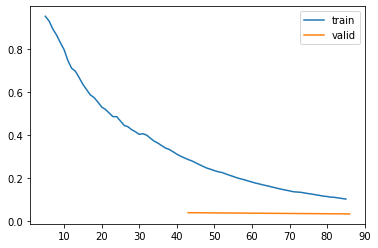

In [24]:
# validation에서 작동이 안 된다면 kernel을 shutdown한 다음 restart를 하자
learn.fit_one_cycle(2,
                   1e-4,
                   cbs=[SaveModelCallback()])
learn.recorder.plot_loss()

# train loss가 0.09 쯤일 때가 가장 좋았다.

# Inference

In [29]:
!pip install opencv-python
clear_output()

     |████████████████████████████████| 60.4 MB 49 kB/s s eta 0:00:01


In [ ]:
# 간단하게 한 장만 확인하는 방법
#learn.predict(file_path+file_name)

In [59]:

img_data = ImageFolder(root="/workspace/dataset/sick/test",
                      transform = transforms)


df = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
test = pd.DataFrame(df)


dtest = ImageDataLoaders.from_df(test, #pass in train DataFrame
                           fn_col='path', 
                           label_col='label',
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           num_workers=NUM_WORKERS, 
                           item_tfms=Resize(IMG_SIZE))


test_dl = dtest.test_dl(test)
preds, _ = learn.tta(dl=test_dl, 
                     n=4, 
                     beta=0.25)

In [61]:
preds

tensor([[4.5950e-01, 7.4765e-02, 1.4075e-01, 3.1243e-01, 1.2555e-02],
        [5.7867e-01, 5.4781e-02, 8.7356e-02, 1.7249e-01, 1.0671e-01],
        [1.6208e-01, 4.4498e-02, 1.8598e-01, 5.9633e-01, 1.1108e-02],
        [2.5560e-01, 7.2178e-01, 1.5820e-02, 3.9050e-03, 2.8952e-03],
        [6.1933e-02, 8.2771e-01, 7.4854e-02, 3.2406e-02, 3.0918e-03],
        [1.1710e-02, 9.8204e-01, 5.2153e-03, 3.3965e-04, 6.9196e-04],
        [1.7913e-01, 8.1184e-01, 7.7034e-03, 4.4844e-04, 8.7500e-04],
        [7.0103e-01, 2.6894e-01, 2.3822e-02, 1.5573e-03, 4.6468e-03],
        [4.4200e-01, 1.4627e-01, 3.6592e-01, 3.5738e-02, 1.0073e-02],
        [1.5312e-03, 1.2748e-03, 9.6461e-01, 3.1999e-02, 5.8602e-04],
        [2.0846e-04, 5.6869e-04, 9.9804e-01, 1.0331e-03, 1.4812e-04],
        [1.3557e-02, 9.8131e-03, 9.1852e-01, 7.3860e-03, 5.0728e-02],
        [8.6255e-03, 2.4436e-03, 6.7023e-03, 9.8035e-01, 1.8818e-03],
        [2.5967e-02, 9.1291e-03, 2.5984e-02, 9.2731e-01, 1.1614e-02],
        [4.1769e-02,

In [74]:
result = [ list(p).index(max(p)) for p in preds]
failed = [i for i in range(len(result)) if result[i] != df['label'][i]]

print(df['label'])
print(result)

# 실패한 이미지들
failed

[0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]
[0, 0, 3, 1, 1, 1, 1, 0, 0, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]


[2, 7, 8]

{'노균병': 0, '녹병': 1, '잿빛곰팡이병': 2, '정상': 3, '흰가루병': 4}


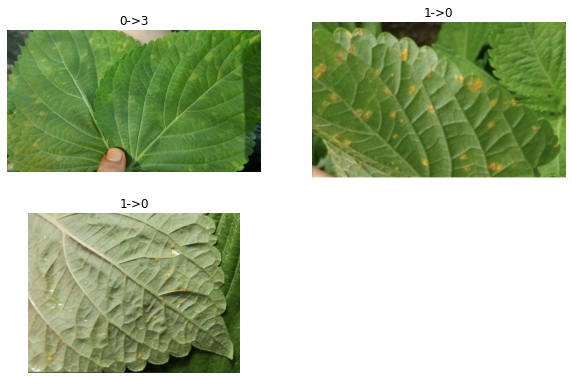

In [86]:
import cv2
import matplotlib.pyplot as plt


print(img_data.class_to_idx)

fig = plt.figure(figsize=(10,10))
rows = len(failed)
cols = 2

nth = 1
for fail in failed:
    img = cv2.imread('/workspace'+df['path'][fail])
    ax = fig.add_subplot(rows, cols, nth)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title( str(df['label'][fail]) + '->' + str(result[fail]))
    ax.axis("off")
    nth += 1
plt.show()

# 실패한 이미지들에 대해서 이미지 보여주기 - 제목 : 정답 -> 오답

In [27]:
#learn.save('failYellow')

Path('models/failYellow.pth')